# Introduction

## Imports and settings

In [33]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

import seaborn as sns

import re
from scipy.fftpack import fft
import pickle
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

from statsmodels.tsa.arima_model import ARIMA
import warnings


## Loading Data

Keys.csv contains only the hashed identification for each page, which is only needed for submission. Hence we will only be loading the relevant data.

In [2]:
data = pd.read_csv('data/train_1.csv')

## Data Structure

In [3]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


The Page title provides us useful information:

- Title
- Kind of access(agent, spider, desktop)
- Country
- Site (wikimedia, wikipedia, etc.)

We can extract this information for some feature engeneering. TimeSeries also seems to display a lot of NaN values. Better fill them when loading csv.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


Data is kind of large, and might run into some problems with a low memory computer (4gb ram).

Notebook moved to a google cloud instance.

## Missing values

In [5]:
nan_count = data.isnull().sum()

/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


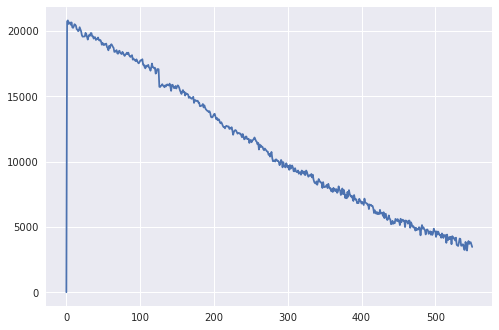

In [6]:
x_vals = [x for x in range(nan_count.shape[0])]
plt.plot(x_vals, nan_count)

In [7]:
sum(nan_count) / (data.shape[0] * (data.shape[1]-1))

0.077620582405262165

About 8% of the values are NaN. We can see that the majority of NaN values are at the beggining of our data, and steadily decreases as time advances. These missing values have to be treated.

Possible strategies:

- Drop series with too much NaN values specified by threshold

- Impute values with a baseline ARIMA prediction

# Data Transformation and Helper Functions

As stated above, the page feature can give us a lot of relevant information. We'll use regular expressions to match the words we want to capture.

In [8]:
# extracting country, agent, site
# ?:foobar, foobar as a non capturing group
# +? 1, *, lazy evaluation

pat = re.compile(
    '(.+)_([a-z]{2}\.)?((?:wikipedia\.org)|(?:commons\.wikimedia\.org)|(?:www\.wikimedia\.org)|(?:www\.mediawiki\.org))_([a-z-]+?)_([a-z-]+)$'
)
print(pat.fullmatch('BLEACH_zh.wikipedia.org_all-access_spider').groups())
print(pat.fullmatch('Accueil_commons.wikimedia.org_all-access_spider').groups())


('BLEACH', 'zh.', 'wikipedia.org', 'all-access', 'spider')
('Accueil', None, 'commons.wikimedia.org', 'all-access', 'spider')


In [9]:
print(pat.fullmatch('"Keep_me_logged_in"_extended_to_one_year_www.mediawiki.org_all-access_all-agents').groups())

('"Keep_me_logged_in"_extended_to_one_year', None, 'www.mediawiki.org', 'all-access', 'all-agents')


This helper function will extract the following information:

- Agent (spider, all-agent)
- Access (all-access, mobile-web, desktop)
- Site (commonly wikipedia.com, mediawiki.com, and variations)
- Country (en, ja, de, fr, es, ru, zh. na is for mediawikis, associated with no country)

In [10]:
def extract_from_url(urls):
    '''
    receives pandas dataframe column or series
    returns a pandas dataframe with all the extracted features
    '''
    
    if isinstance(urls, pd.Series):
         urls = urls.values
    
    accesses = np.full_like(urls, np.NaN)
    agents = np.full_like(urls, np.NaN)
    sites = np.full_like(urls, np.NaN)
    countries = np.full_like(urls, np.NaN)
    titles = np.full_like(urls, np.nan)
    
    for i in range(len(urls)):
        url = urls[i]
        match = pat.fullmatch(url)
        assert match, "regex pattern matching failed %s" % url
        
        titles[i] = match.group(1)
        
        country = match.group(2)
        if country:
            countries[i] = country[:-1]
        else:
            countries[i] = 'na'
            
        sites[i] = match.group(3)
        
        agents[i] = match.group(4)
        accesses[i] = match.group(5)
        
    return pd.DataFrame({
        'page': urls,
        'title': titles,
        'agent': agents,
        'access': accesses,
        'site': sites,
        'country': countries,
    })

urls = data.Page
extract = extract_from_url(urls)

/home/allen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


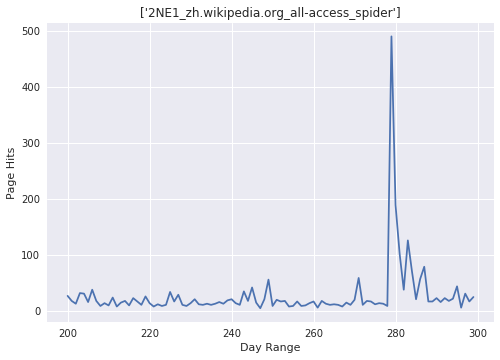

In [11]:
def plot_series(series, start=None, end=None):
    '''
    Receives a series to plot
    series will have first column as start page
    '''
    series = series.reshape(-1, 1)
    title = series[0]
    series = np.delete(series, 0) 
    
    if start and end:
        df = series[start:end]
    elif start:
        df = series[start:]
        end = series.shape[0]
    elif end:
        df = series[:end]
        start = 0
    else:
        df = series
        start = 0
        end = series.shape[0]
        
    x_vals = [x for x in range(start, end)]
    
    plt.title(title)
    plt.xlabel('Day Range')
    plt.ylabel('Page Hits')
    plt.plot(x_vals, df)

plot_series(data.loc[0], start=200, end=300)

# Parameters analysis

Before delving deeper into the data, let's see what kind of accesses these pages are getting.
Assert where most traffic comes from (mobie or desktop), how these accesses are made (crawler or not), and if there are any significant differences in volume of data between languages.

In [16]:
country_data = extract.country.value_counts()
agent_data = extract.agent.value_counts()
access_data = extract.access.value_counts()

In [17]:
country_data

en    24108
ja    20431
de    18547
na    17855
fr    17802
zh    17229
ru    15022
es    14069
Name: country, dtype: int64

/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


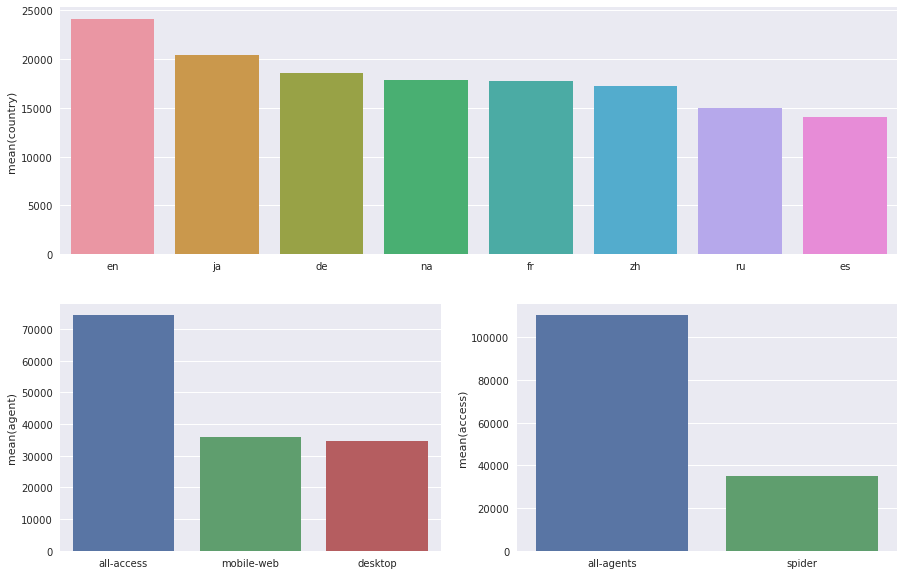

In [18]:
plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid((2,2), (0, 0), colspan=2) #country data
ax2 = plt.subplot2grid((2,2), (1, 0)) # agent data
ax3 = plt.subplot2grid((2,2), (1, 1)) # access data



sns.barplot(x=country_data.index, y=country_data, ax=ax1)
sns.barplot(x=agent_data.index, y=agent_data, ax=ax2)
sns.barplot(x=access_data.index, y=access_data, ax=ax3)
plt.show()

It seems the majority of data is from the English wikipedia as expected. Since it is the most used language across the globe, the results make sense. Surprisingly the Japanese wikipedia is the second wiki with most data. Pages per country vary between ~[14.000, 24.000]. 

Mobile access to wikipedia is slightly more frequent.

About 1/3 of the agents accessing wikipedia are crawlers.

# Data Visualization

## By Language

Different cultures, different customs! We'll get a nice first overlook at the data aggregated by country, and check if there is any underlying phenomena unique to each country. 

Is periodicity the same for all countries?
Any trends unique to any country?

We'll proceed to more specific data as we progress.

In [19]:
data['lang'] = extract.country

In [20]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,lang
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,zh
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,zh
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0,zh


In [21]:
lang_sets = {}
lang_sets['en'] = data[data.lang =='en'].iloc[:, 0:-2]
lang_sets['ja'] = data[data.lang =='ja'].iloc[:, 0:-2]
lang_sets['de'] = data[data.lang =='de'].iloc[:, 0:-2]
lang_sets['fr'] = data[data.lang =='fr'].iloc[:, 0:-2]
lang_sets['zh'] = data[data.lang =='zh'].iloc[:, 0:-2]
lang_sets['ru'] = data[data.lang =='ru'].iloc[:, 0:-2]
lang_sets['es'] = data[data.lang =='es'].iloc[:, 0:-2]
lang_sets['na'] = data[data.lang =='na'].iloc[:, 0:-2]

In [22]:
sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:, 1:].sum(axis=0) / lang_sets[key].shape[0]

In [23]:
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }


/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


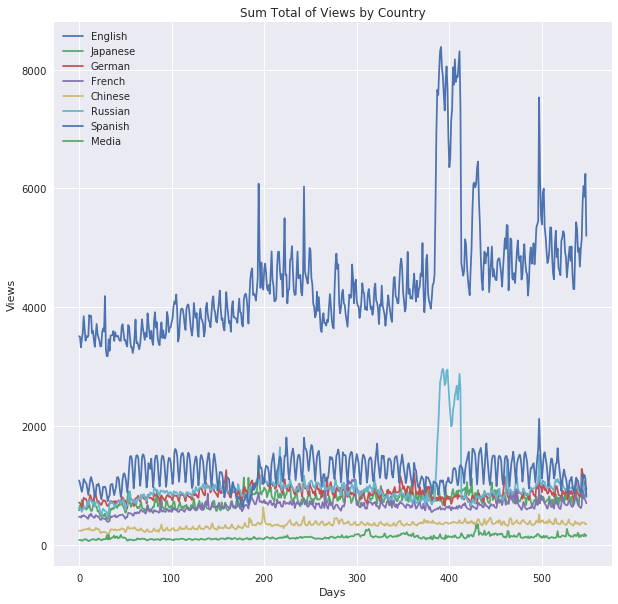

In [34]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1, figsize=[10, 10])
plt.ylabel('Views per page')
plt.xlabel('Days')


for key in sums:
    plt.plot(days, sums[key], label = labels[key])

plt.title('Sum Total of Views by Country')
plt.legend()
plt.show()

We can clearly see that the english wiki has more page hits, as expected.

Both the english and russian wikis display a huge spike around day 400, indicating that normalizing the data might be useful in order to get rid of these outliers.

The spanish wiki displays a very clear periodic structure, varying within a 1 week time window. After 180 days the view count dips a little, and then comes back within the same value range, indicating a seasonal component as well.

We can observe in most languages that the data displays several spikes. This is very natural as people usually search more, when a certain event is happening, or something was shown on the news recently. Normalize data with log1p() transform as suggested by 1st place solution, might be helpful here.

A first look at this indicates that data is majorly stationary.

## Top Pages for each wiki

Let's see the general structure of the data for the most visited pages in wikipedia. I expect them to be the main pages, or the main access portal for these websites.

In [35]:
n_pages = 5
top_pages = {}

for key in lang_sets:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values('total', ascending=False)
    print(sum_set.head(3))
    top_pages[key] = sum_set.index[0]
    print('\n\n')

en
                                                   Page         total
38573  Main_Page_en.wikipedia.org_all-access_all-agents  1.204003e+10
9774      Main_Page_en.wikipedia.org_desktop_all-agents  8.754906e+09
74114  Main_Page_en.wikipedia.org_mobile-web_all-agents  3.150045e+09



ja
                                                 Page        total
120336  メインページ_ja.wikipedia.org_all-access_all-agents  210254229.0
86431      メインページ_ja.wikipedia.org_desktop_all-agents  133948459.0
123025   特別:検索_ja.wikipedia.org_all-access_all-agents   70221197.0



de
                                                     Page         total
139119  Wikipedia:Hauptseite_de.wikipedia.org_all-acce...  1.600648e+09
116196  Wikipedia:Hauptseite_de.wikipedia.org_mobile-w...  1.110989e+09
67049   Wikipedia:Hauptseite_de.wikipedia.org_desktop_...  4.264619e+08



fr
                                                    Page        total
27330  Wikipédia:Accueil_principal_fr.wikipedia.org_a...  866939253.0
551

/home/allen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


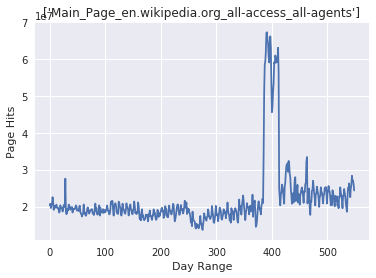

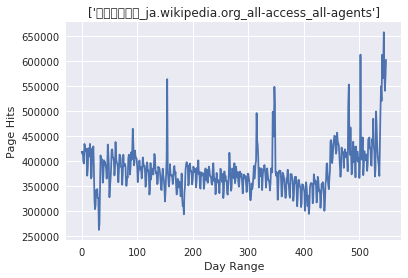

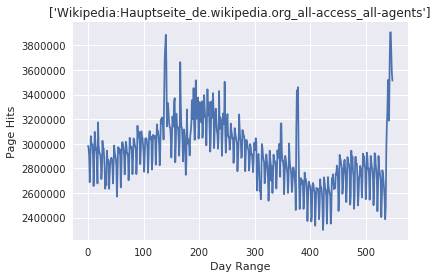

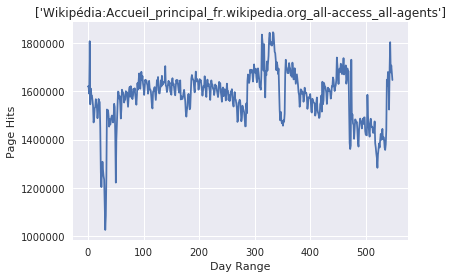

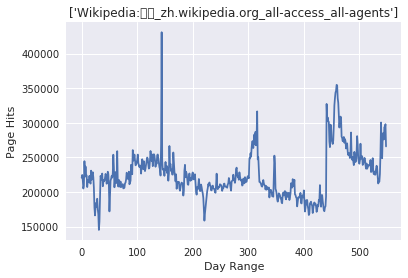

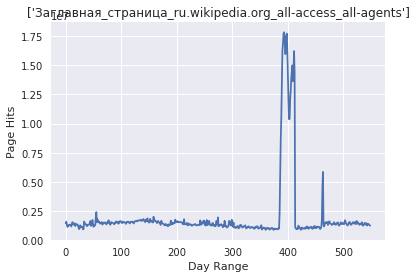

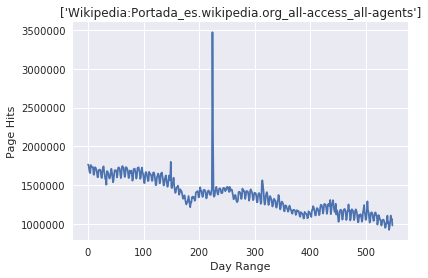

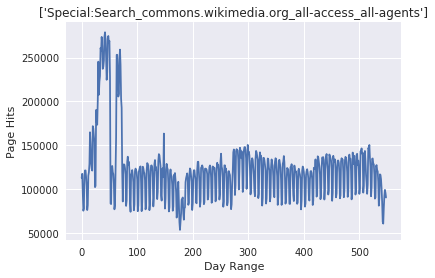

In [39]:
for key in top_pages:
    cols = data.columns[0:-2]
    plot_series(data.loc[top_pages[key], cols])
    plt.show()

We can still observe the huge spike at around day 400 for both the English and Russian pages. 

Although, for the rest of the data we cannot observe the same behaviour, perhaps indicating that the aggregated data by language will not prove very useful:

- The Japanese and Chinese main page display a decreasing trend from day 0 to 400, which continues but with an overall increase in traffic from day 400 to 500.
- The German main page displays a strong seasonal component displaying a maximum traffic at around day 200, decreasing until day 400. At the very end we can observe that traffic increases again, with a huge spike. Indicates that half-year autocorrelation might be useful.
- The French main page shows a huge downward spike at the beggining, but maintains overall traffic throughout
- The Spanish main page shows a decreasing trend overall, with the presence of a huge spike at around day 220.
- As for the media page, with two spikes at the beggining, but overall shows stability.

The data shows some different patterns between languages. Some reflect the observations seen in the aggregated data, while some show overall trends that were not captured. We end up losing information if we aggregate the data by language, which might not prove a good forecasting strategy after all.

## Individual Entries

In [51]:
def plot_entry(key, idx):
    article = lang_sets[key].iloc[idx, 1:]
    
    fig = plt.figure(1, figsize=(10,5))
    plt.plot(days, article)
    plt.xlabel('days')
    plt.ylabel('views')
    plt.title(data.iloc[lang_sets[key].index[idx],0])
    
    plt.show()

/home/allen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


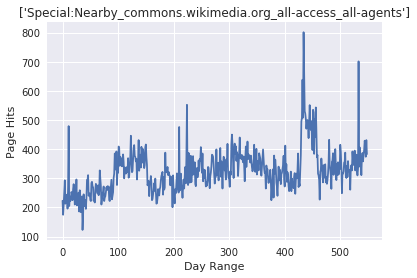

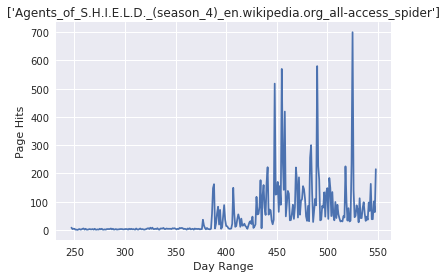

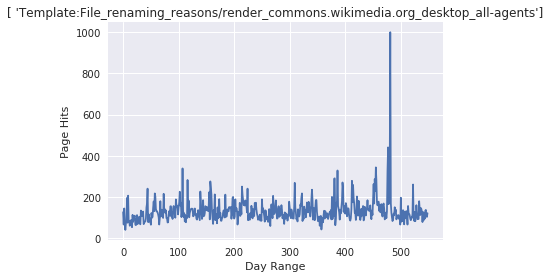

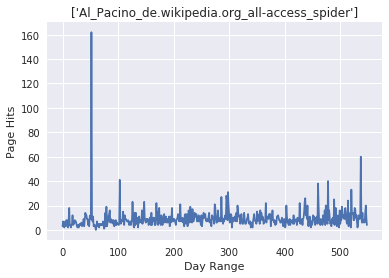

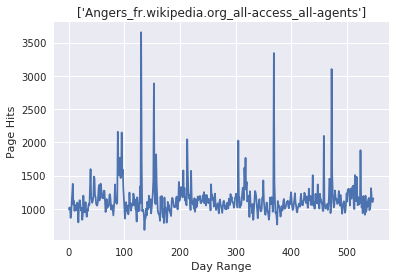

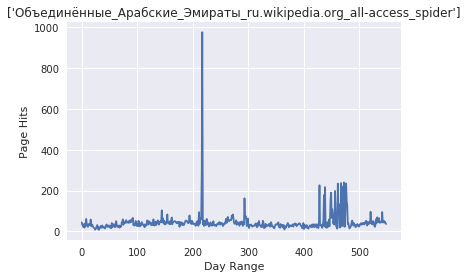

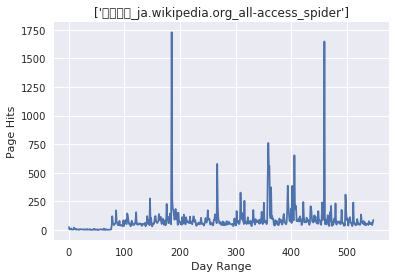

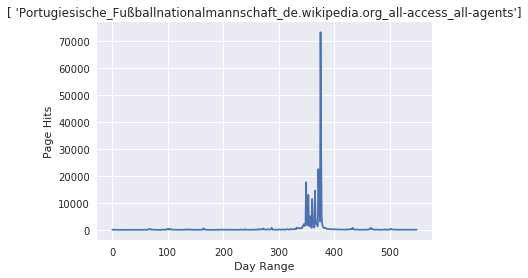

In [45]:
for key in lang_sets:
    rnd_idx = np.random.randint(data.shape[0])
    plot_series(data.loc[rnd_idx, cols])
    plt.show()

We can observe 3 different patterns of traffic here:

- Pages that get almost no traffic and then suffer from a huge spike, again indicating that something might have appeared on the news that made people search for it.
- Pages with moderate average traffic, that suffer occasional spikes.
- Pages with moderate to high constant traffic, that have an occasional spike, but not as noticeable.

Maybe clustering these types of pages, might be a useful feature.
We can cluster by SAX signature, with median etc.

# Stationarity Analysis

Stationarity of a wave/signal means that the mean, standard deviation and autocorrelation remain constant over time, meaning they are not time dependent variables. So, it also doesn't display any trends.

Why is this helpful?
From a statistical point of view, a sample is more useful if it can maintain its individual structure, instead of depending on another samples. Stationarity is a way to model the dependence structure of the data. A lot of nice statistical results that come from the law of large numbers, and the central limit theorem, also hold for stationary random variables. So stationarity, is a powerful tool when modelling non-independent data, as it is the case for most time series. Thus, some time series analysis algorithms assume from the get-go that the signal is stationary, or try to achieve it. Not having a stationary series can cause spurrious causation, meaning that the model might correlate two features that are correlated by time, but might not have a direct causal relatioship.

In [65]:
from statsmodels.tsa.stattools import adfuller

# using augmented dickie fuller test
def test_stationarity(timeseries, window=30):
    #rolling statistics
    rol_mean = timeseries.rolling(window=window).mean()
    rol_std = timeseries.rolling(window=window).std()
    
    #plot rolling statistics
    orig = plt.plot(timeseries.values, color='blue', label='orig')
    mean = plt.plot(rol_mean.values, color='red', label='mean')
    std = plt.plot(rol_std.values, color='black', label='std')
    plt.legend(loc='best')
    
    plt.title('rolling means and std')
    plt.show(block=False)
    
    #dickey fuller test
    print('fuller test')
    df_test = adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#lags used', '#observations used'])
    
    for key, value in df_test[4].items():
        df_output['critical value (%s)' %key] = value
    print(df_output)

A (Augmented) Dickie Fuller test allows us to test is series is stationary. Dickie Fuller proposes the following null-hypothesis : series is non-stationary. So for significant p-value we can reject the hypothesis. We can also reject the null hypothesis if the test-statistic is less than the critical values in absolute value. 

Main_Page_en.wikipedia.org_all-access_all-agents


/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


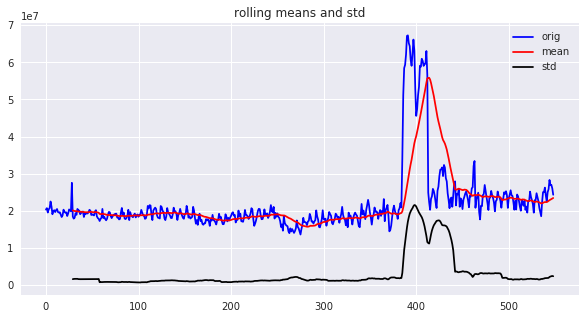

fuller test
Test Statistic           -2.997309
p-value                   0.035147
#lags used               15.000000
#observations used      533.000000
critical value (1%)      -3.442678
critical value (5%)      -2.866978
critical value (10%)     -2.569666
dtype: float64



メインページ_ja.wikipedia.org_all-access_all-agents


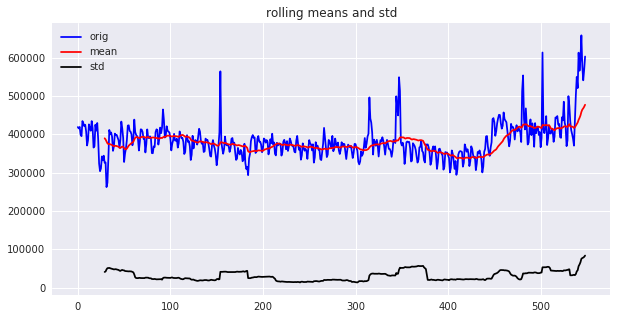

fuller test
Test Statistic           -1.079897
p-value                   0.723022
#lags used               14.000000
#observations used      534.000000
critical value (1%)      -3.442655
critical value (5%)      -2.866968
critical value (10%)     -2.569661
dtype: float64



Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents


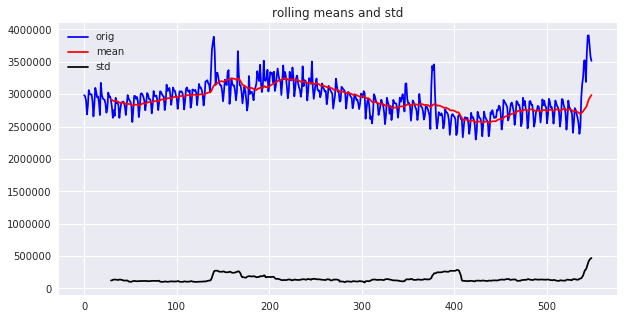

fuller test
Test Statistic           -1.536740
p-value                   0.515265
#lags used               19.000000
#observations used      529.000000
critical value (1%)      -3.442772
critical value (5%)      -2.867019
critical value (10%)     -2.569688
dtype: float64



Wikipédia:Accueil_principal_fr.wikipedia.org_all-access_all-agents


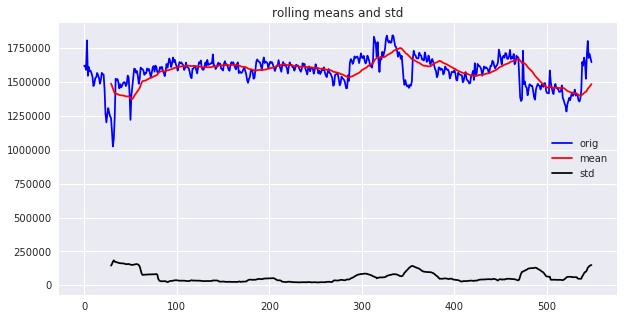

fuller test
Test Statistic           -3.580455
p-value                   0.006146
#lags used               14.000000
#observations used      534.000000
critical value (1%)      -3.442655
critical value (5%)      -2.866968
critical value (10%)     -2.569661
dtype: float64



Wikipedia:首页_zh.wikipedia.org_all-access_all-agents


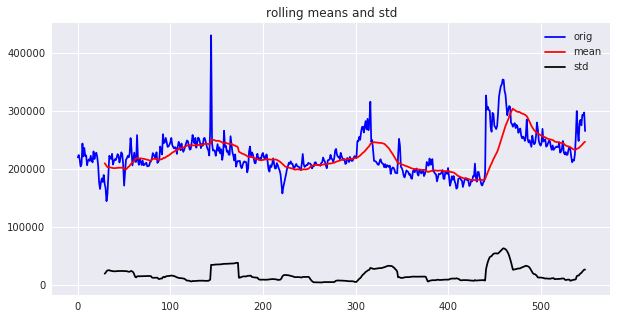

fuller test
Test Statistic           -2.648631
p-value                   0.083357
#lags used               14.000000
#observations used      534.000000
critical value (1%)      -3.442655
critical value (5%)      -2.866968
critical value (10%)     -2.569661
dtype: float64



Заглавная_страница_ru.wikipedia.org_all-access_all-agents


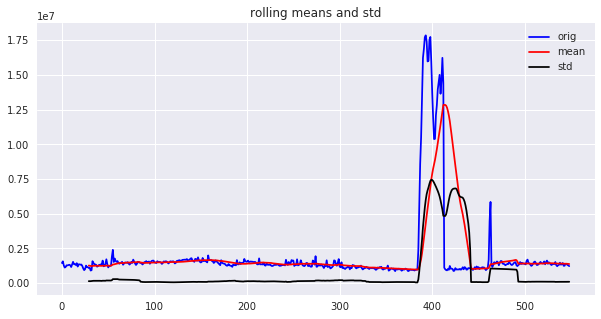

fuller test
Test Statistic           -4.125663
p-value                   0.000878
#lags used                4.000000
#observations used      544.000000
critical value (1%)      -3.442428
critical value (5%)      -2.866868
critical value (10%)     -2.569607
dtype: float64



Wikipedia:Portada_es.wikipedia.org_all-access_all-agents


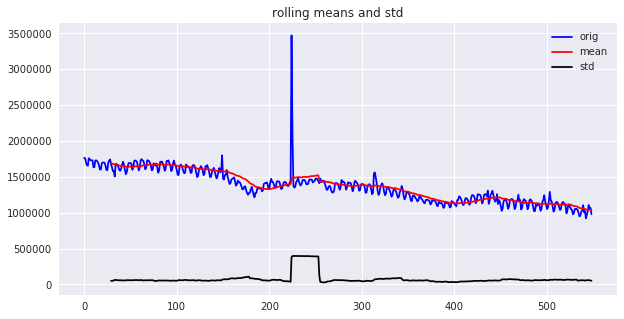

fuller test
Test Statistic           -1.000749
p-value                   0.752991
#lags used               13.000000
#observations used      535.000000
critical value (1%)      -3.442632
critical value (5%)      -2.866957
critical value (10%)     -2.569655
dtype: float64



Special:Search_commons.wikimedia.org_all-access_all-agents


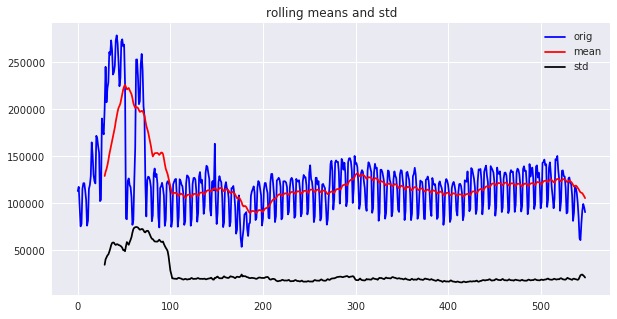

fuller test
Test Statistic           -2.984770
p-value                   0.036341
#lags used               15.000000
#observations used      533.000000
critical value (1%)      -3.442678
critical value (5%)      -2.866978
critical value (10%)     -2.569666
dtype: float64





In [68]:
for key in top_pages:
    fig = plt.figure(1, figsize=(10,5))
    
    
    cols = data.columns
    cols = cols[1:-2]
    df = data.loc[top_pages[key]]
    print(df.Page)
    test_stationarity(df[cols])
    print('\n\n')
#df.rolling(window=30).mean()

We can observe that some data is stationary, whereas some is not.
After some standardization and normalization data should prove mostly stationary.

# Decomposition

As observed earlier the traffic data displays some strong periodicity. By looking at the magnitude of Fast Fourier Transforms we can look at the strongest frequencies in this signal. 

We'll check period at 1 week, half-week, and 1/3week.

/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


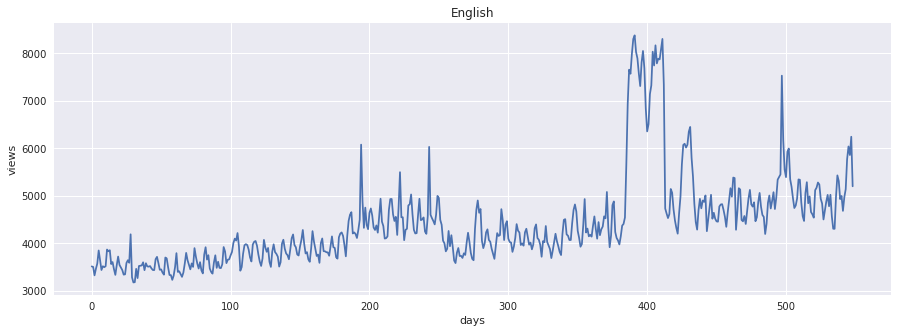

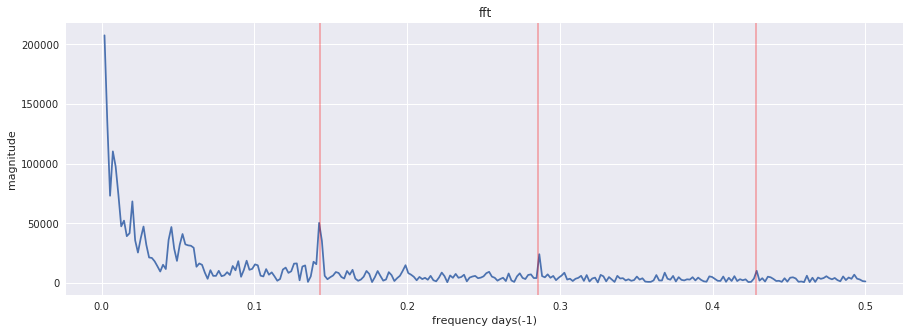

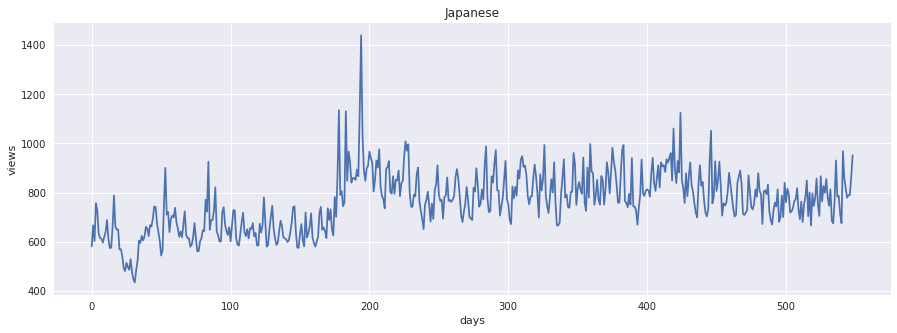

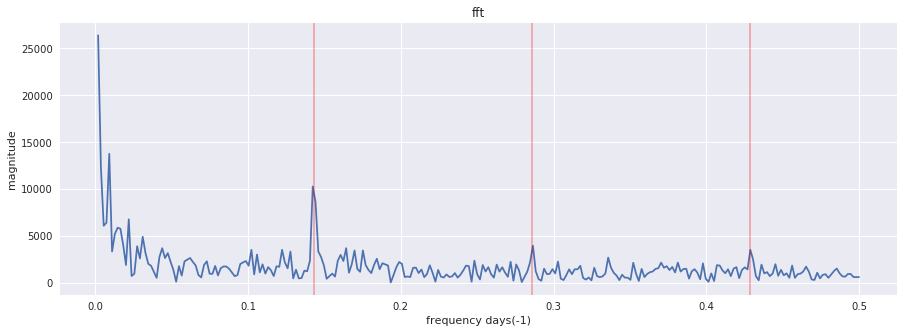

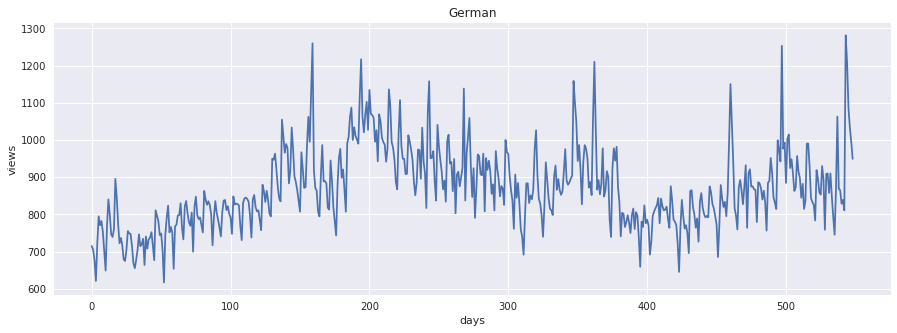

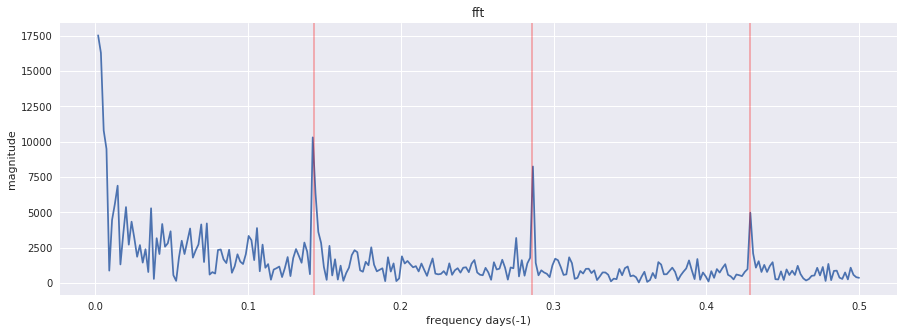

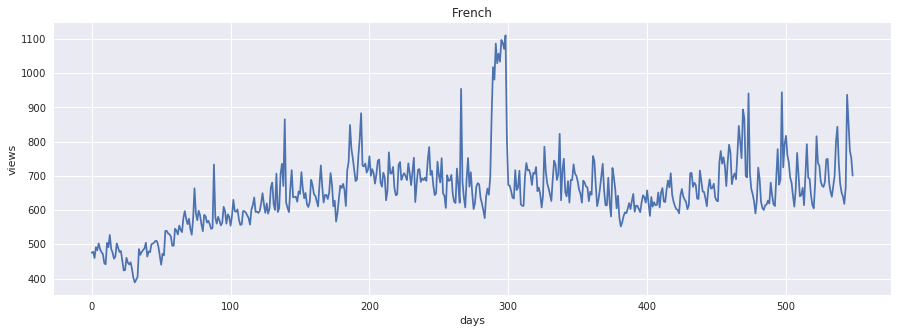

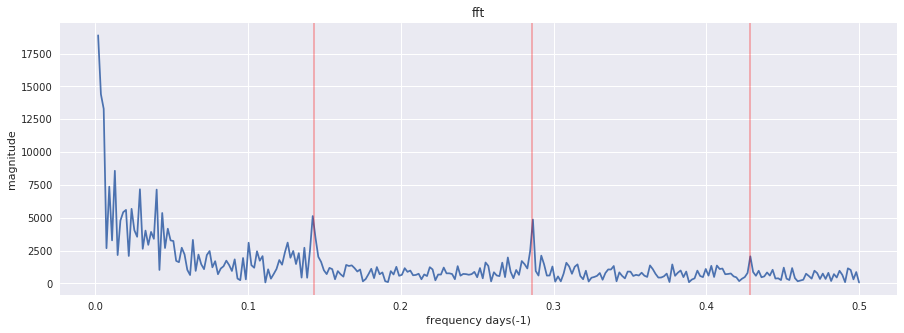

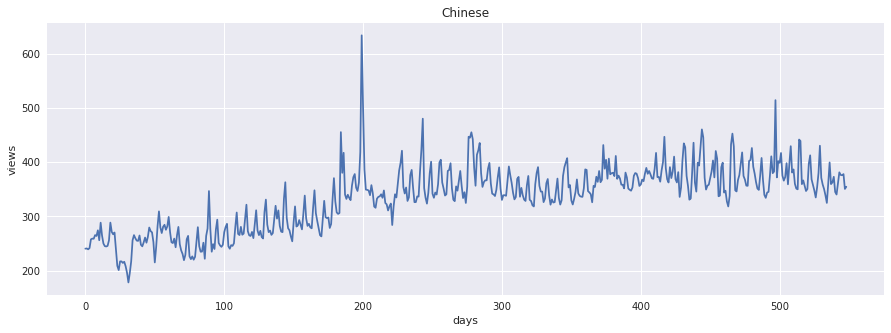

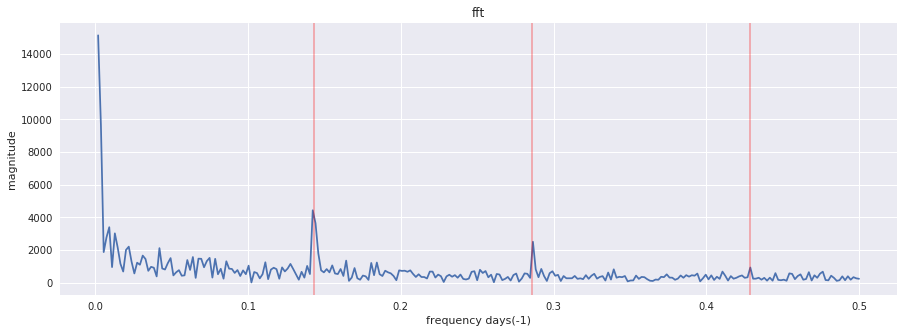

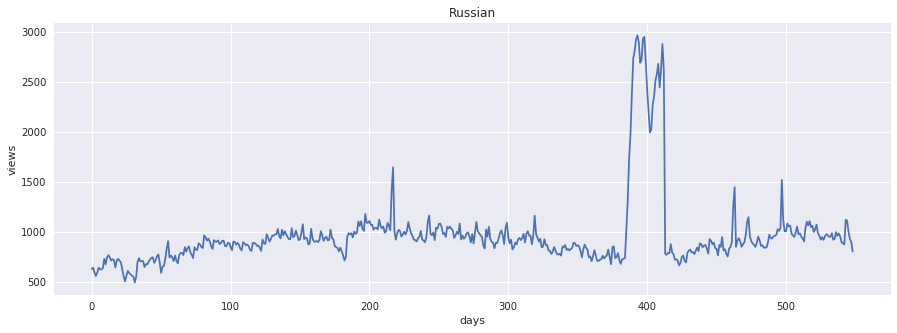

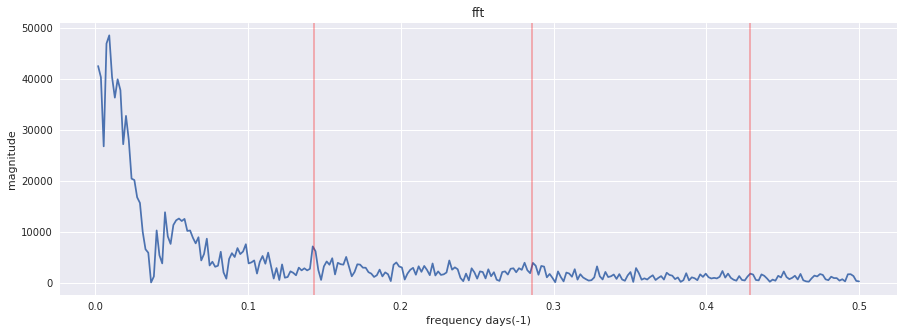

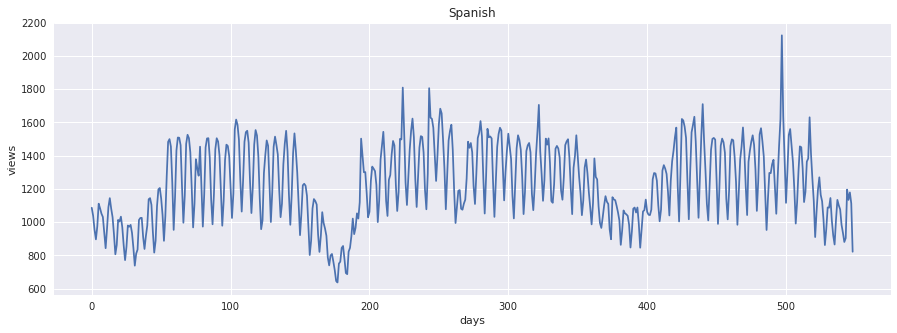

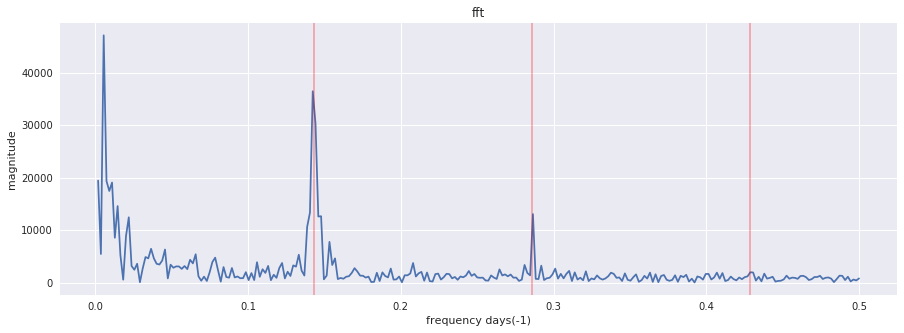

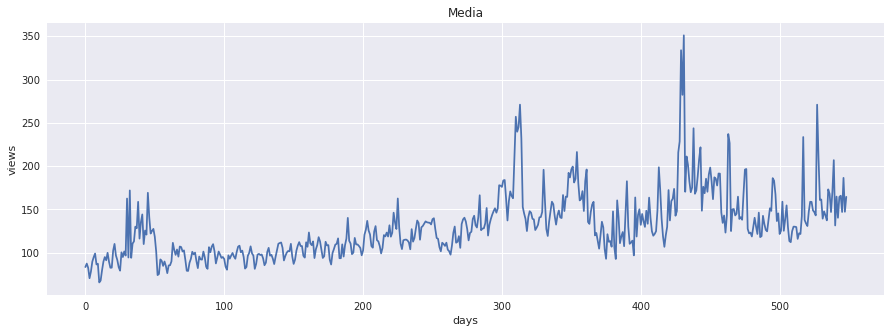

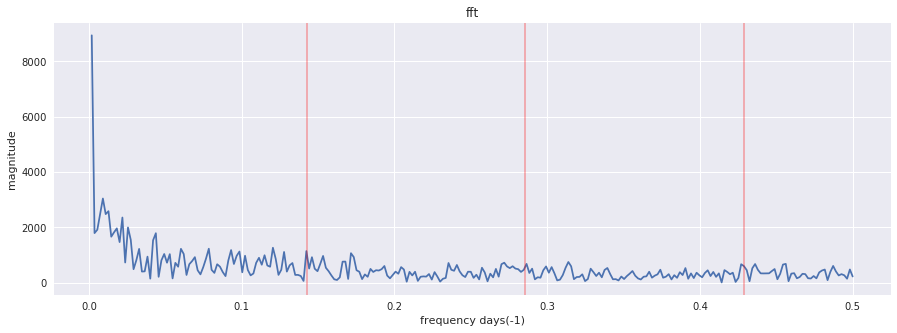

In [69]:
def plot_fft(key):
    
    fig = plt.figure(1, figsize=[15,5]) 
    plt.ylabel('views')
    plt.xlabel('days')
    plt.title(labels[key])
    plt.plot(days, sums[key], label=labels[key])
    
    fig = plt.figure(2, figsize=[15,5]) 
    fft_complex = fft(sums[key])
    
    # r^2 + i^2
    fft_mag = [np.sqrt(np.real(x) * np.real(x) + np.imag(x)*np.imag(x)) 
              for x in fft_complex]
    fft_xvals = [day/ days[-1] for day in days]
    
    npts = len(fft_xvals) // 2 + 1
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
    
    plt.ylabel('magnitude')
    plt.xlabel('frequency days(-1)')
    plt.title('fft')
    plt.plot(fft_xvals[1:], fft_mag[1:], label = labels[key])
    
    plt.axvline(x=1./7, color='red', alpha=0.3)
    plt.axvline(x=2./7, color='red', alpha=0.3)
    plt.axvline(x=3./7, color='red', alpha=0.3)
    
    plt.show()
    
for key in sums:
    plot_fft(key)

German and Spanish data display the most strong periodic features. As for the Russian and Media data, they don't appear to have such a strong periodic component. The other languages all display mild periodicity. 

This can be explained by the observations made earlier. Data from page views is not smooth at all, and can present a couple of varying patterns. The occasional spikes that mostly every page gets, will be hard to predict.

In [70]:
pickle_out = open('pickle/data.pkl', 'wb')
pickle.dump(data, pickle_out)
pickle_out.close()

In [71]:
pickle_out = open('pickle/top_pages.pkl', 'wb')
pickle.dump(top_pages, pickle_out)
pickle_out.close()

In [72]:
pickle_out = open('pickle/langs.pkl', 'wb')
pickle.dump(lang_sets, pickle_out)
pickle_out.close()

# Autocorrelation

Autocorrelation arises when there exists correlation between the same variables over time (for time series data). So, correlation is calculated with a time series versus its lagged version (by a defined time-step). As stated earlier, this implies that our data is not instance independent, thus being dependent on time.

Autocorrelation takes into account the correlation from lag 0 until lag N, while partial autocorrelation only displays the autocorrelation at the lag N (doesn't take into account all the other lags prior to N).

/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


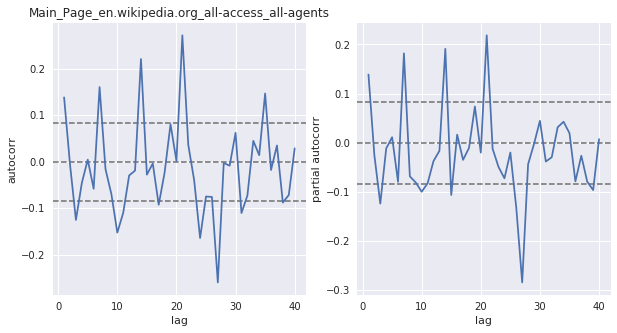

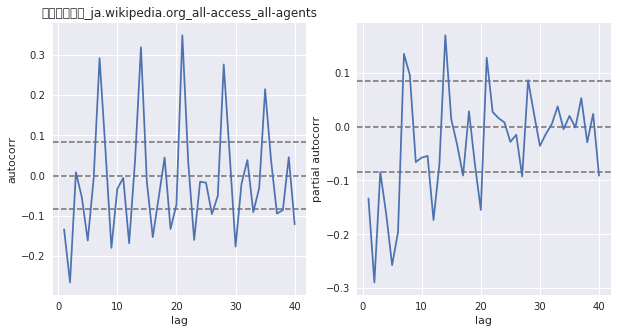

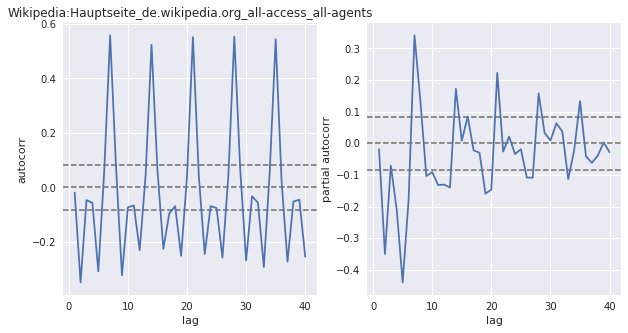

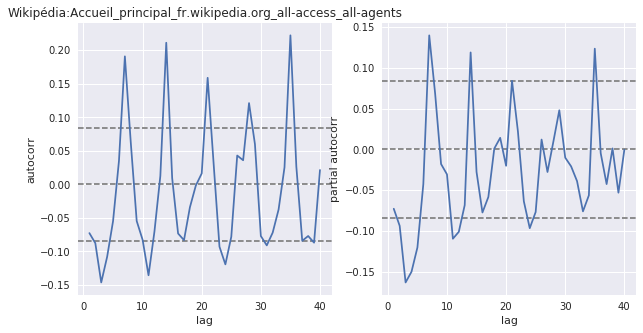

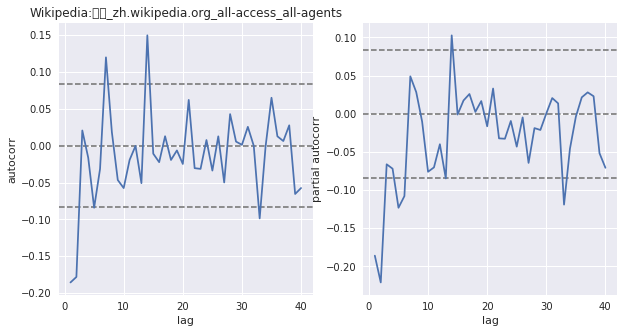

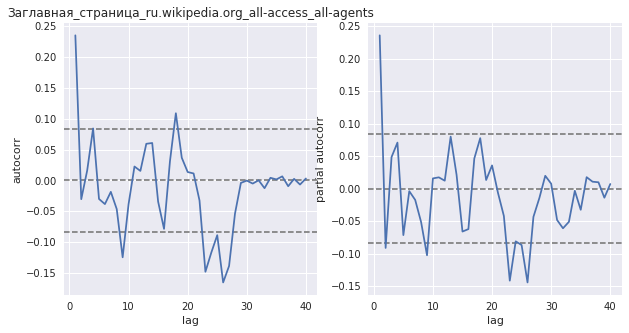

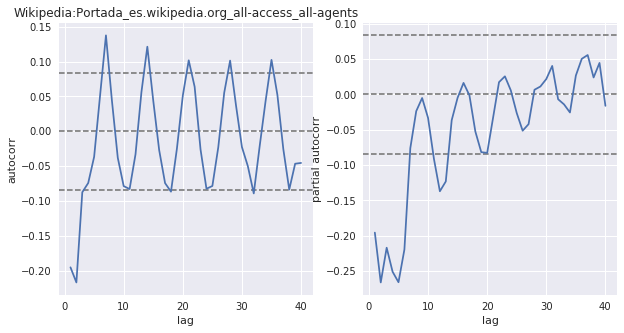

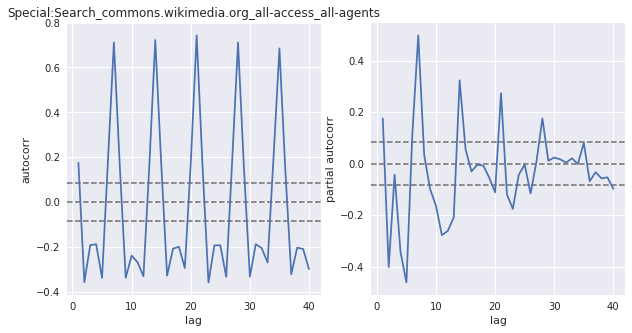

In [79]:
# autocorrelation and partial autocorrelation of top pages
for key in top_pages:
    fig = plt.figure(1, figsize=(10,5))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    
    cols = data.columns[1:-2]
    tseries = np.array(data.loc[top_pages[key], cols])
    tseries_diff = [tseries[i] - tseries[i-1] for i in range(1, len(tseries))]
    
    autocorr = acf(tseries_diff)
    pautocorr = pacf(tseries_diff)
    
    ax1.axhline(y=0,linestyle='--',color='gray')
    ax1.axhline(y=-1.96/np.sqrt(len(tseries_diff)),linestyle='--',color='gray')
    ax1.axhline(y=1.96/np.sqrt(len(tseries_diff)),linestyle='--',color='gray')
    ax2.axhline(y=0,linestyle='--',color='gray')
    ax2.axhline(y=-1.96/np.sqrt(len(tseries_diff)),linestyle='--',color='gray')
    ax2.axhline(y=1.96/np.sqrt(len(tseries_diff)),linestyle='--',color='gray')
    
    x = [x for x in range(len(pautocorr))]
    ax1.plot(x[1:], autocorr[1:])
    ax1.set_xlabel('lag')
    ax1.set_ylabel('autocorr')
    ax1.set_title(data.loc[top_pages[key], 'Page'])
    
    ax2.plot(x[1:], pautocorr[1:])
    ax2.set_xlabel('lag')
    ax2.set_ylabel('partial autocorr')
    plt.show()

From the ACF plots we can observe correlations within a 7 day period, similarly to the observations made with the Discrete Fourier Transforms. Suggests 2 to 4 MA terms.

The PACF plot shows that this correlation is stronger in the first week and then decreases over time, over the course of a month. Mostly suggests 2 AR terms.

# ARIMA

In [74]:
data = pickle.load(open('pickle/data.pkl', 'rb'))
top_pages = pickle.load(open('pickle/top_pages.pkl', 'rb'))
lang_sets = pickle.load(open('pickle/langs.pkl', 'rb'))

1484917.86666 




/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


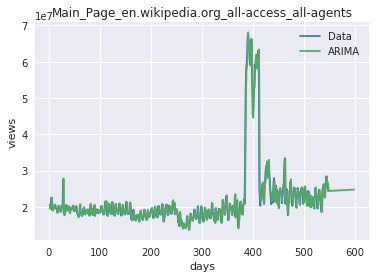

20703.8923886 




/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


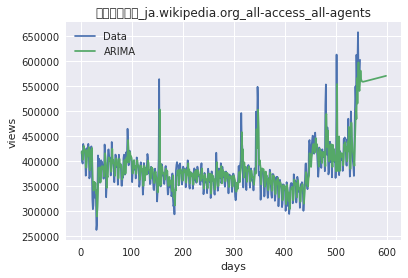

119852.145864 




/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


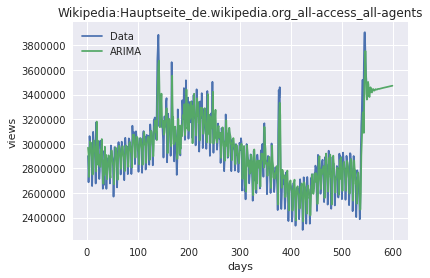

37497.2568307 




/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


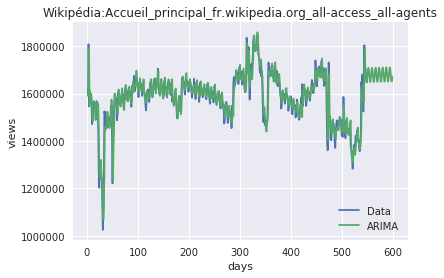

7964.65954081 




/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


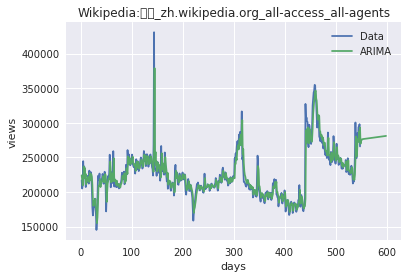

260042.432824 




/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


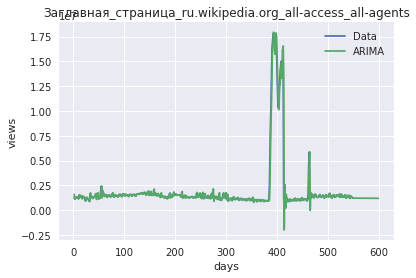

65992.629833 




/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


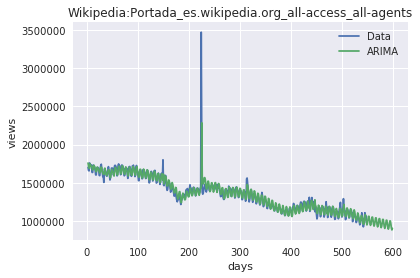

25222.7004472 




/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


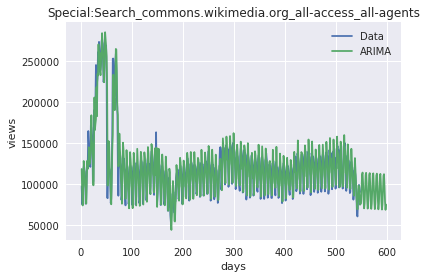

In [98]:
cols = data.columns[1:-2]
for key in top_pages:
    tseries = np.array(data.loc[top_pages[key], cols], 'f')
    result = None
 
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(tseries,[2,1,4])
            result = arima.fit(disp=False)
 
        except:
            try:

                arima = ARIMA(tseries,[2,1,2])
                result = arima.fit(disp=False)
            except:
                print(data.loc[top_pages[key],'Page'])
                print('\tARIMA failed')

    # levels -> convert back to original scale
    pred = result.predict(2, 599, typ='levels')

    error = mean_absolute_error(tseries, pred[:len(tseries)])
    print(error, '\n\n')
    x = [i for i in range(600)]
    i=0
    
    plt.plot(x[2:len(tseries)], tseries[2:], label='Data')
    plt.plot(x[2:], pred, label='ARIMA')
    plt.title(data.loc[top_pages[key], 'Page'])
    plt.xlabel('days')
    plt.ylabel('views')
    plt.legend()
    plt.show()

/home/allen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/allen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/allen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1845367.6171 




/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


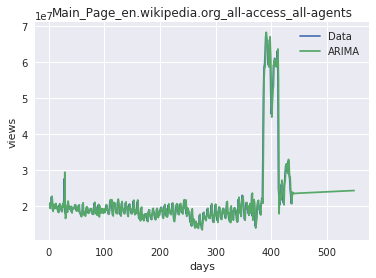

86638.9425843 




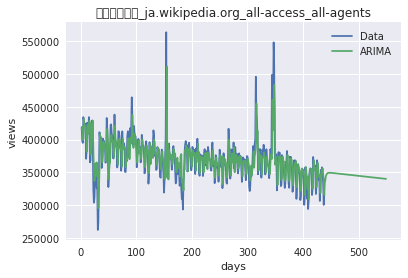

322773.71535 




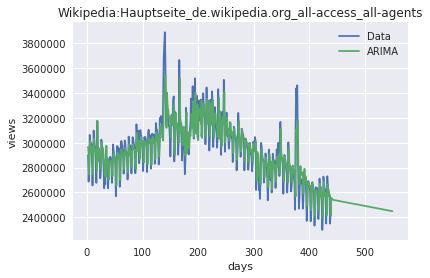

151013.35559 




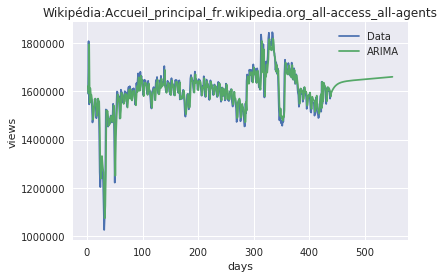

89069.7425979 




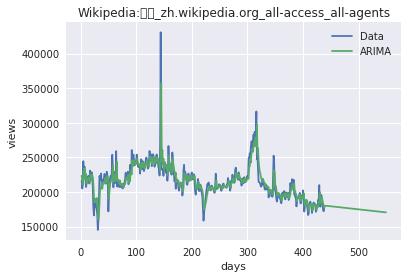

457888.383147 




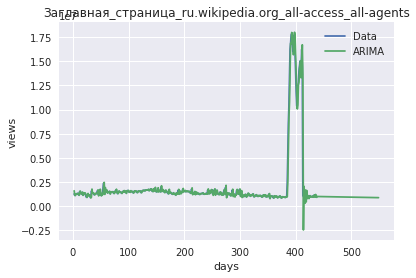

55238.0057862 




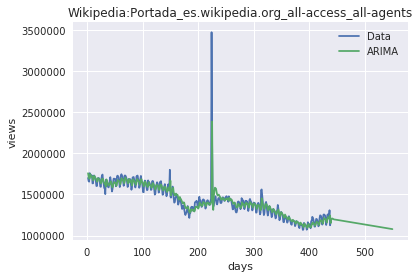

18447.297082 




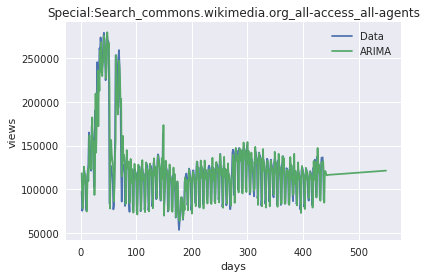

In [93]:
from sklearn.metrics import mean_absolute_error

cols = data.columns[1:-2]
for key in top_pages:
    tseries = np.array(data.loc[top_pages[key], cols], 'f')
    size = 0.8 * len(tseries)
    train = tseries[:size]
    test = tseries[size:]
    result = None
 
    arima = ARIMA(train,[2,1,2])
    result = arima.fit(disp=False)
 
    # levels -> convert back to original scale
    pred = result.predict(2, len(tseries), typ='levels')
    forecast = pred[size-1:]

    x = [i for i in range(len(tseries) +1) ]
    i=0
    
    error = mean_absolute_error(test, forecast)
    print(error, '\n\n')
    plt.plot(x[2:len(train)], train[2:], label='Data')
    plt.plot(x[2:], pred, label='ARIMA')
    plt.title(data.loc[top_pages[key], 'Page'])
    plt.xlabel('days')
    plt.ylabel('views')
    plt.legend()
    plt.show()

Our ARIMA baseline seems good in capturing the overall structure of each series, especially the weekly structure of the data. 

When extrapolating it seems the model just gives a linear fit. This might be good with missing values.

# Decisions

Our data needs normalization in order to take care of much present spikes, and also get the data stationarized. 

Feature Engeneering:

- Agent, access, country
- Model seasonalities and trends, that may be lost in normalization (average views, median views)
- Day of the week (to capture weekly seasonality)
- Year autocorrelation
- Cluster pages by Symbolic Aggregation Approximation signature (also capturing the type of article - popular, specific, etc.)

Take care of missing data with an ARIMA baseline, and get rid of dirty series.